In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches
import seaborn as sns


In [ ]:
combined

event                                            scardec ye  \
0     20170818_0259     FCTs_20170818_025925_NORTH_OF_ASCENSION_ISLAND  0   
1     20110126_1542   FCTs_20110126_154229_NORTHERN_SUMATRA__INDONESIA  0   
2     19981010_1629  FCTs_19981010_162908_MINAHASSA_PENINSULA__SULA...  0   
3     19920730_0824                        FCTs_19920730_082446_XIZANG  0   
4     19960327_2052       FCTs_19960327_205206_NEAR_COAST_OF_NICARAGUA  0   
...             ...                                                ... ..   
5610  20230206_1024                                                  0  0   
5611  20231202_1437                                                  0  0   
5612  19971108_1002                                                  0  0   
5613  20181220_1701                                                  0  0   
5614  20240628_0536                                                  0  0   

      isc          sigloch                 usgs    mag  
0       0                0                    0  6.591  
1       0  0706.2011.026.a                    0  6.114  
2       0                0                    0  5.927  
3       0                0                    0  6.017  
4       0                0                    0  6.157  
...   ...              ...                  ...    ...  
5610    0                0  20230206_102448.txt    NaN  
5611    0                0  20231202_143704.txt    NaN  
5612    0                0  19971108_100252.txt    NaN  
5613    0                0  20181220_170155.txt    NaN  
5614    0                0  20240628_053636.txt    NaN  

[5615 rows x 7 columns]

In [3]:
time = 1

In [4]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [5]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [6]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    if usgs_name == '19950205_225105.txt' or usgs_name == '20041226_005853.txt':
        momentrate = momentrate
    elif int(usgs_name[0:4]) < 2021:
        momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    elif int(usgs_name[0:4]) == 2021:
        if int(usgs_name[4:6]) < 5:
            momentrate = momentrate / 10**7
    else:
        momentrate = momentrate
    return momentrate, time

In [7]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [8]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [9]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [10]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [11]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [12]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [13]:
def moment_in_different_windows(window = None, window_prop = None, combined=None):
#def moment_in_different_windows(window = None, window_prop = None, combined=None):
    #window = 1
    #window_prop = None
    if combined is None:
        combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')
        combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']
    if window is None and window_prop is None:
        window_prop = 1

    simpson = []

    simpson_short = []

    durations = []

    magnitudes = []

    datasets = []

    names = []

    depths = []
    
    to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

    for i, row in combined.iterrows():

        for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):
        #for dataset, get_stf in zip(['sigloch'], [get_sigloch_stf]):

            if dataset == 'scardec_moy' or dataset == 'scardec_opt':
                name = row[dataset[:-4]]
            else:
                name = row[dataset]

            if name == '0' or name == 0:
                continue

            if dataset == 'scardec_moy':
                momentrate, time = get_stf(name, 'fctmoy')
            elif dataset == 'scardec_opt':
                momentrate, time = get_stf(name, 'fctopt')
            else:
                momentrate, time = get_stf(name)

            if dataset != 'sigloch':
                momentrate_list = [momentrate]
                time_list = [time]
            else:
                momentrate_list = momentrate
                time_list = time

            count = 0
            for momentrate, time in zip(momentrate_list, time_list):
                if time[0] == time[1]:
                    time = time[1:]
                
                if dataset != 'sigloch':
                    save_key = row.event
                    dataset_name = dataset
                else:
                    dataset_name = dataset + '_' + str(count)
                    save_key = row.event + '_' + str(count)

                if save_key in to_ignore:
                    continue
                
                momentrate = np.array(momentrate)

                time = np.array(time)
                detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
                time = time[detected_start:detected_end] # shift to start STF at zero
                
                start = 0
                #end = len(momentrate)
                duration = time[-1] - time[0]
                #durations.append(duration)
                momentrate = momentrate[detected_start:detected_end]
                start = 0
                #end = len(momentrate)
                duration = time[-1] - time[0]
                durations.append(duration)
                end = len(momentrate)
                dx = time[1]-time[0]
                
                simpson.append(scipy.integrate.simpson(momentrate[start:end], dx = time[1]-time[0]))

                if window_prop is None: #using static time window
                    end_window = int(round((window/dx), 0))    #int((end-start)*(window/duration))
                else: #based on proportion of duration
                    end_window = int((duration)*window_prop)

                # print(duration, window, end_window, end, dx)
                # print(start, start+end_window)
                # print(dx * window)

                if window < dx:
                    ynew = np.interp(np.linspace(0, dx*2, window), time[0:2], momentrate[0:2])
                    simpson_short.append(scipy.integrate.simpson(ynew[0:1]))

                #if duration == end_window:
                
                else:
                    simpson_short.append(scipy.integrate.simpson(momentrate[start:start + end_window], dx = time[1]-time[0]))

                if row.event in catalog['event'].values:
                    event_cat = catalog[catalog['event']==row.event]
                    print(row.event)
                    print(event_cat)
                    magnitudes.append(event_cat['magnitude'].values[0])
                    depths.append(event_cat['depth/km'].values[0])
                else:
                    magnitudes.append(row.mag)
                    depths.append(np.nan)

                datasets.append(dataset_name)
                names.append(name)
    return names, simpson, simpson_short, durations, magnitudes, datasets, depths

In [20]:
names, simpson, simpson_short, durations, magnitudes, datasets, depths = moment_in_different_windows(window = time)

20170818_0259
              event  catalog_id  year month day hour minute  latitude  \
3387  20170818_0259    10393952  2017    08  18   02     59   -1.0907   

      longitude  depth/km  magnitude  int_magnitude magtype  
3387   -13.6631      10.0        6.6              7     Mww  
20170818_0259
              event  catalog_id  year month day hour minute  latitude  \
3387  20170818_0259    10393952  2017    08  18   02     59   -1.0907   

      longitude  depth/km  magnitude  int_magnitude magtype  
3387   -13.6631      10.0        6.6              7     Mww  
20110126_1542
              event  catalog_id  year month day hour minute  latitude  \
6832  20110126_1542     3276652  2011    01  26   15     42     2.165   

      longitude  depth/km  magnitude  int_magnitude magtype  
6832    96.8128      23.8        6.0              6      MW  
20110126_1542
              event  catalog_id  year month day hour minute  latitude  \
6832  20110126_1542     3276652  2011    01  26   15     4

In [21]:
simpson = np.array(simpson)
simpson_short = np.array(simpson_short)
durations = np.array(durations)
magnitudes = np.array(magnitudes)
depths = np.array(depths)


In [22]:
colors = cmc.batlow(np.linspace(0, 1, 5))
unique_datasets = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']
dataset_colors = {dataset: colors[i] for i, dataset in enumerate(unique_datasets)}

In [23]:
datasets_for_colors = []
for d in datasets:
	datasets_for_colors.append(d.split('_')[0])

In [27]:
db = pd.DataFrame({'name': names,
				   'magnitude': magnitudes, 
				   'depth': depths,
				   'simpson': simpson, 
				   'simpson_short': simpson_short, 
				   'dataset': datasets_for_colors})

In [28]:
subset = db[db['simpson'] > 10**16]
subset = subset[subset['simpson_short'] > 0]

spearman_r, spearman_p = stats.spearmanr(subset['simpson'], subset['simpson_short'])
print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')

m, b = np.polyfit(np.log10(subset['simpson']), np.log10(subset['simpson_short']), 1)
#m, b = np.polyfit(simpson, simpson_short, 1)

Spearman correlation: 0.5170547798177886, p-value: 0.0


In [35]:
bars

<BarContainer object of 10 artists>

[Text(0, 0, '66.90%'),
 Text(0, 0, '9.16%'),
 Text(0, 0, '4.67%'),
 Text(0, 0, '2.87%'),
 Text(0, 0, '2.15%'),
 Text(0, 0, '2.01%'),
 Text(0, 0, '1.97%'),
 Text(0, 0, '1.84%'),
 Text(0, 0, '1.82%'),
 Text(0, 0, '6.60%')]

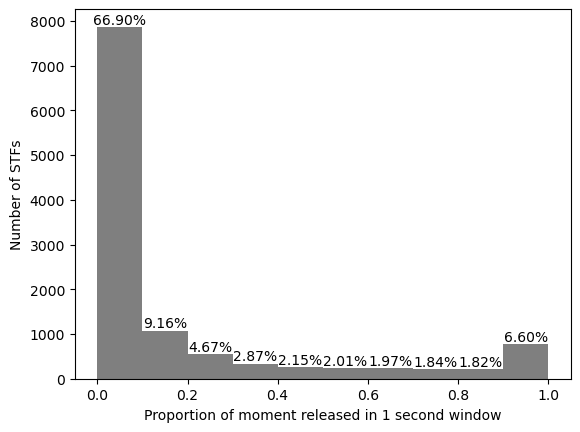

In [43]:
values, bins, bars = plt.hist(db['simpson_short']/db['simpson'], bins = np.arange(0, 1.1, 0.1), color = 'k', alpha = 0.5)
sum_values = sum(values)
labels = []
for i, v in enumerate(values):
	labels.append(f'{(v/sum_values)*100:.2f}%')
plt.ylabel('Number of STFs')
plt.xlabel('Proportion of moment released in 1 second window')
plt.bar_label(bars, labels, fontsize=10, color='k')

[0.85748642 0.07686826 0.06564532]


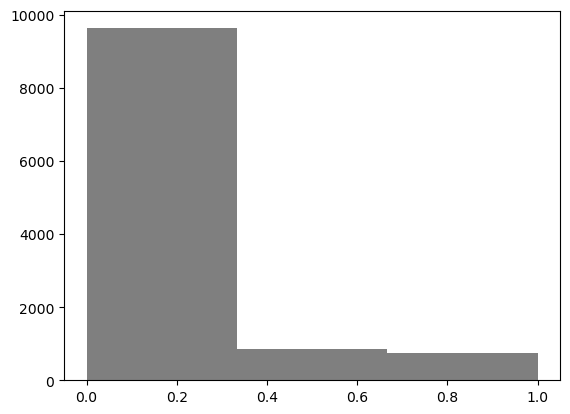

In [46]:
values, bins, bars = plt.hist(db['simpson_short']/db['simpson'], bins = [0, 0.3333, 0.6666, 0.9999], color = 'k', alpha = 0.5)
print(values/sum(values))

In [47]:
1-0.85748642

0.14251358000000003

In [26]:
subset = db[db['depth'] < 70]

In [883]:
subset = subset[subset['dataset'] == dataset]
subset = subset[subset['simpson'] > 10**16]
subset = subset[subset['simpson_short'] > 0]

In [884]:
subset

name  magnitude   depth       simpson  simpson_short  \
21     20120320_180247.txt        7.5  19.400  1.194007e+20   2.406388e+18   
111    20200623_152904.txt        7.4  20.000  1.019129e+20   4.181914e+18   
133    20161225_142227.txt        7.6  38.000  2.336611e+20   2.945970e+18   
156    20190615_225504.txt        7.3  46.000  1.069137e+20   3.062174e+18   
190    20110820_165502.txt        7.1  34.600  5.528505e+19   1.866083e+18   
...                    ...        ...     ...           ...            ...   
11760  20230206_102448.txt        7.5  10.000  4.412318e+20   4.043929e+18   
11761  20231202_143704.txt        7.6  50.675  2.924153e+20   1.318501e+18   
11762  19971108_100252.txt        7.4  38.100  2.005195e+20   3.038227e+18   
11763  20181220_170155.txt        7.3  16.560  1.169586e+20   1.932563e+18   
11764  20240628_053636.txt        7.2  24.442  5.715358e+19   8.475906e+17   

      dataset  
21       usgs  
111      usgs  
133      usgs  
156      usgs  
190      usgs  
...       ...  
11760    usgs  
11761    usgs  
11762    usgs  
11763    usgs  
11764    usgs  

[205 rows x 6 columns]

In [886]:
np.log10(subset['simpson_short'])

21       18.381366
111      18.621375
133      18.469228
156      18.486030
190      18.270931
           ...    
11760    18.606804
11761    18.120080
11762    18.482620
11763    18.286134
11764    17.928186
Name: simpson_short, Length: 205, dtype: float64

Spearman correlation: 0.528764498165642, p-value: 0.0
5980 5980
Spearman correlation: -0.06074299006839297, p-value: 0.38693534570154187
205 205
Spearman correlation: 0.9369939651219074, p-value: 0.0
2136 2136
Spearman correlation: 0.36063682394135577, p-value: 0.00014611589381256202
106 106
Spearman correlation: 0.8827258497316638, p-value: 1.7608981306786992e-43
129 129
Spearman correlation: 0.5861426202564355, p-value: 0.0


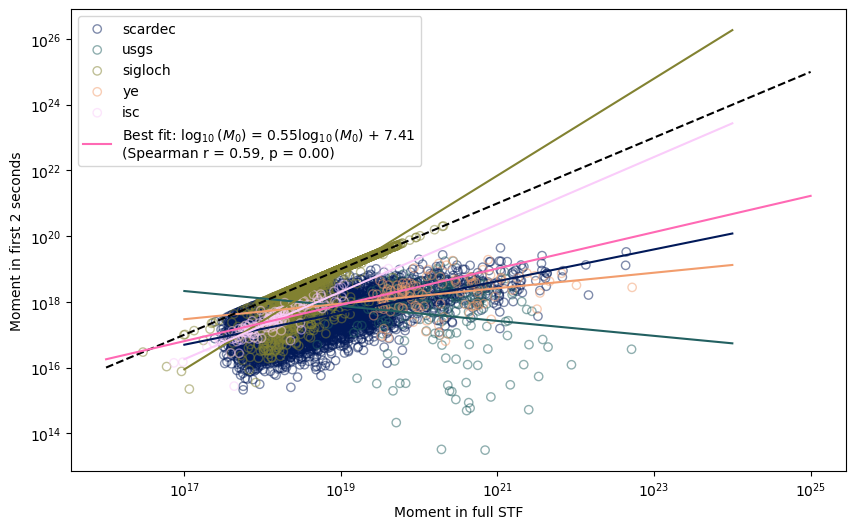

In [889]:
colors = cmc.batlow(np.linspace(0, 1, 5))
unique_datasets = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']
dataset_colors = {dataset: colors[i] for i, dataset in enumerate(unique_datasets)}

shallow = db[db['depth'] < 70]

plt.figure(figsize=(10, 6))
for dataset in unique_datasets:
	subset = shallow[shallow['dataset'] == dataset]
	subset = subset[subset['simpson'] > 10**16]
	subset = subset[subset['simpson_short'] > 0]
	if dataset != 'usgs':
		subset_no_nan = subset.dropna()
		subset = subset_no_nan[abs(subset_no_nan['magnitude']-2/3*(np.log10(subset_no_nan['simpson'])-9.1)) < 1]
	plt.scatter(subset['simpson'], subset['simpson_short'], label=dataset, alpha=0.5, facecolors='none', edgecolors=dataset_colors[dataset])

	spearman_r, spearman_p = stats.spearmanr(subset['simpson'], subset['simpson_short'])
	print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')
	print(len(subset['simpson']), len(subset['simpson_short']))
	m, b = np.polyfit(np.log10(subset['simpson']), np.log10(subset['simpson_short']), 1)
	#m, b = np.polyfit(simpson, simpson_short, 1)

	plt.plot(np.array([10e16, 10e19, 10e23]),
			10**(m * np.log10(np.array([10e16, 10e19, 10e23])) + b),
			c=dataset_colors[dataset],
			linestyle = '-')


plt.xlabel('Moment in full STF')
plt.ylabel('Moment in first 2 seconds')

plt.plot([10**16, 10**25], [10**16, 10**25], ls='--', c='k')


subset = shallow[shallow['simpson'] > 10**16]
subset = subset[subset['simpson_short'] > 0]

spearman_r, spearman_p = stats.spearmanr(subset['simpson'], subset['simpson_short'])
print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')

m, b = np.polyfit(np.log10(subset['simpson']), np.log10(subset['simpson_short']), 1)
#m, b = np.polyfit(simpson, simpson_short, 1)

plt.plot(np.array([10e15, 10e19, 10e24]),
		10**(m * np.log10(np.array([10e15, 10e19, 10e24])) + b),
		c='hotpink',
		label = fr'Best fit: $\log_{{10}}(M_0)$ = {m:.2f}$\log_{{10}}(M_0)$ + {b:.2f}' + '\n' + f'(Spearman r = {spearman_r:.2f}, p = {spearman_p:.2f})',
		linestyle = '-')


plt.yscale('log')
plt.xscale('log')

#plt.xlim(5,10)

plt.legend()
#plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_in_absolute_time/moment_in_{time}_seconds.png')
plt.show()

In [828]:
datasets_for_colors_2 = []
for d in datasets:
	if d.split('_')[0] == 'sigloch':
		datasets_for_colors_2.append(d.split('_')[0])
	else:
		datasets_for_colors_2.append(d)

In [829]:
db_2 = pd.DataFrame({'name': names, 'magnitude': magnitudes, 'simpson': simpson, 'simpson_short': simpson_short, 'dataset': datasets_for_colors_2})

Spearman correlation: 0.5954395736041069, p-value: 0.0
Spearman correlation: 0.5327784833470017, p-value: 3.1751638402420104e-298
Spearman correlation: -0.012307772916612086, p-value: 0.847692108561401
Spearman correlation: 0.9511737463012797, p-value: 0.0
Spearman correlation: 0.3690482809748865, p-value: 7.851398511404162e-05
Spearman correlation: 0.8855072573272182, p-value: 4.0036180081739187e-50


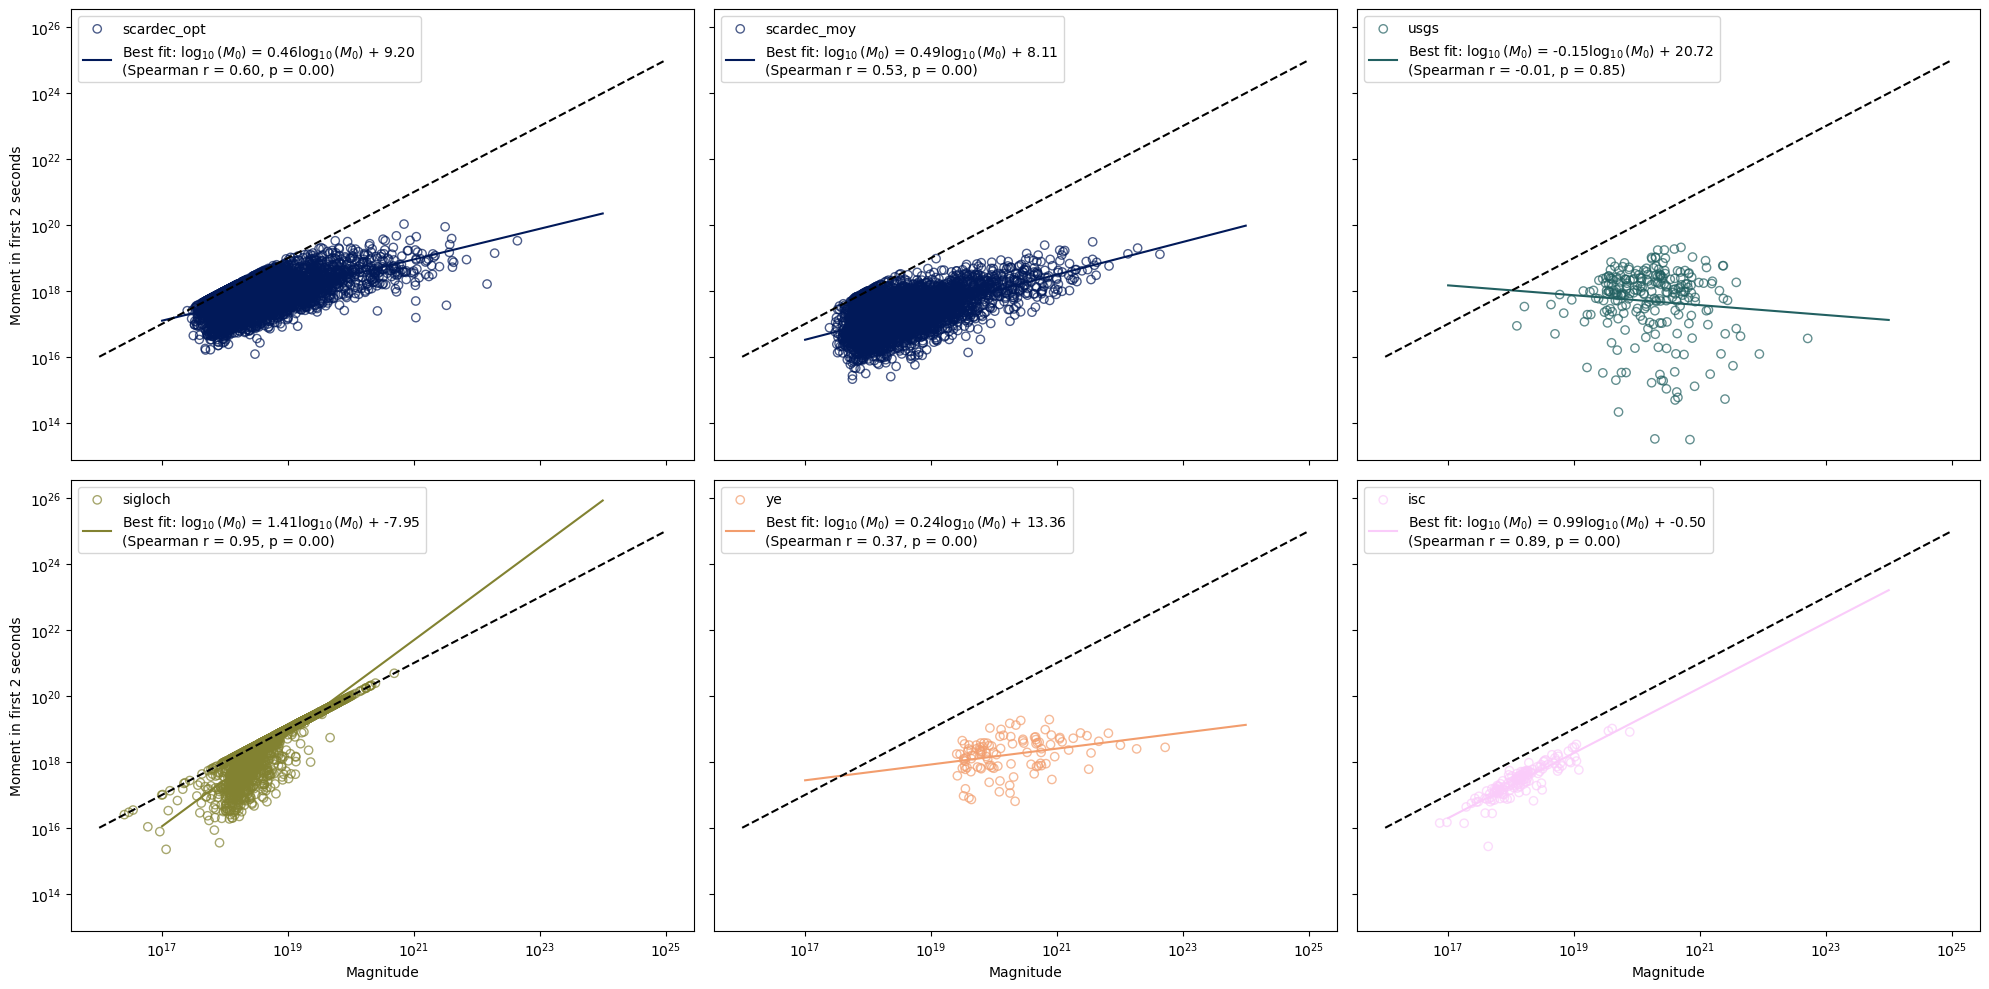

In [830]:
colors = cmc.batlow(np.linspace(0, 1, 5))
unique_datasets = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']
dataset_colors = {dataset: colors[i] for i, dataset in enumerate(unique_datasets)}

unique_datasets_2 = ['scardec_opt', 'scardec_moy', 'usgs', 'sigloch', 'ye', 'isc']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True, sharex=True)

for i, dataset in enumerate(unique_datasets_2):
	ax = axes[i//3, i%3]
	subset = db_2[db_2['dataset'] == dataset]
	subset = subset[subset['simpson'] > 10**16]
	subset = subset[subset['simpson_short'] > 0]
	if dataset != 'usgs':
		subset_no_nan = subset.dropna()
		subset = subset_no_nan[abs(subset_no_nan['magnitude']-2/3*(np.log10(subset_no_nan['simpson'])-9.1)) < 1]
	ax.scatter(subset['simpson'], subset['simpson_short'], label=dataset, alpha=0.7, facecolors='none', edgecolors=dataset_colors[dataset.split('_')[0]])
	#ax.set_xlim(5, 10)
	ax.set_yscale('log')
	ax.set_xscale('log')


	spearman_r, spearman_p = stats.spearmanr(subset['simpson'], subset['simpson_short'])
	print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')

	m, b = np.polyfit(np.log10(subset['simpson']), np.log10(subset['simpson_short']), 1)
	#m, b = np.polyfit(simpson, simpson_short, 1)

	ax.plot(np.array([10e16, 10e19, 10e23]),
			10**(m * np.log10(np.array([10e16, 10e19, 10e23])) + b),
			c=dataset_colors[dataset.split('_')[0]],
			label = fr'Best fit: $\log_{{10}}(M_0)$ = {m:.2f}$\log_{{10}}(M_0)$ + {b:.2f}' + '\n' + f'(Spearman r = {spearman_r:.2f}, p = {spearman_p:.2f})',
			linestyle = '-')



	ax.plot([10**16, 10**25], [10**16, 10**25], ls='--', c='k')

	ax.legend()

	if i%3 == 0:
		ax.set_ylabel(f'Moment in first {time} seconds')
	if i//3 == 1:
		ax.set_xlabel('Magnitude')

plt.tight_layout()
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_in_absolute_time/moment_in_{time}_seconds_dataset.png')

plt.show()

In [831]:
subset = db[db['dataset'] == 'sigloch']

(array([3.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        2.548e+03, 1.486e+03, 2.010e+02, 1.900e+01]),
 array([0.    , 0.8794, 1.7588, 2.6382, 3.5176, 4.397 , 5.2764, 6.1558,
        7.0352, 7.9146, 8.794 ]),
 <BarContainer object of 10 artists>)

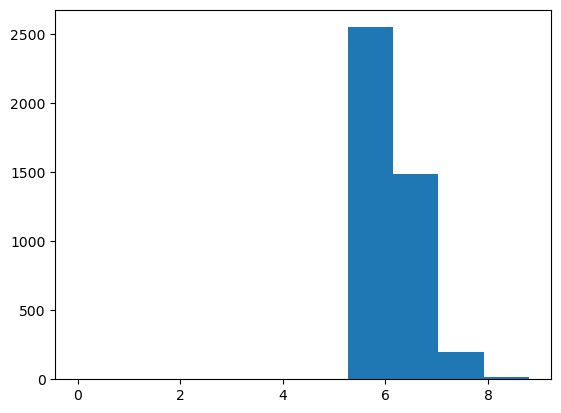

In [832]:
plt.hist(subset.magnitude)

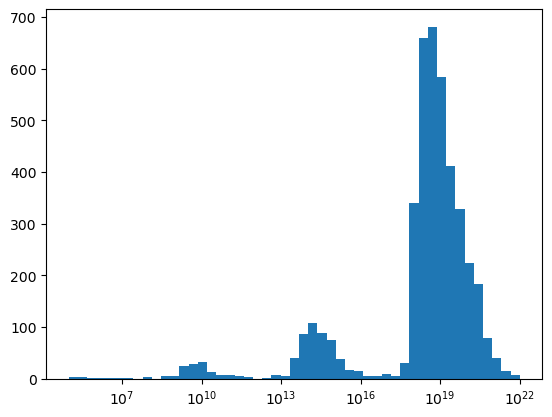

In [833]:
plt.hist(subset['simpson'], bins = np.logspace(5, 22, 50))
plt.xscale('log')

In [15]:
def myround(x, base=1):
    return base * round(x/base)

In [16]:
catalog = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_m55_catalog.csv', sep = '|')
cols = catalog.columns
column_names = []
for c in cols:
    column_names.append(c.strip().rstrip().lower())
column_names[0] = 'catalog_id'
catalog.columns = column_names
catalog['year'] = catalog.apply(lambda x: x['time'][:4], axis = 1)
catalog['month'] = catalog.apply(lambda x: x['time'][5:7], axis = 1)
catalog['day'] = catalog.apply(lambda x: x['time'][8:10], axis = 1)
catalog['hour'] = catalog.apply(lambda x: x['time'][11:13], axis = 1)
catalog['minute'] = catalog.apply(lambda x: x['time'][14:16], axis = 1)

catalog['event'] = catalog.apply(lambda x: x['year'] + x['month'] + x['day'] + '_' + x['hour'] + x['minute'], axis = 1)

catalog['int_magnitude'] = catalog.apply(lambda x: myround(x['magnitude']), axis = 1)
catalog.drop(columns = ['contributor', 'contributorid', 'magauthor', 'eventlocationname', 'author', 'catalog', 'time'], inplace = True)
catalog = catalog[['event', 'catalog_id', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'depth/km', 'magnitude', 'int_magnitude', 'magtype']]

In [17]:
catalog

event  catalog_id  year month day hour minute  latitude  \
0      20250121_1115    11926233  2025    01  21   11     15   -3.7368   
1      20250121_0605    11926190  2025    01  21   06     05  -27.4829   
2      20250121_0547    11926184  2025    01  21   05     47   13.4344   
3      20250120_1617    11926033  2025    01  20   16     17   23.2338   
4      20250120_0838    11925968  2025    01  20   08     38  -11.3327   
...              ...         ...   ...   ...  ..  ...    ...       ...   
16101  19900108_1944     2808110  1990    01  08   19     44   52.0105   
16102  19900107_0906     2808066  1990    01  07   09     06  -15.9527   
16103  19900106_2144     2808053  1990    01  06   21     44  -10.6437   
16104  19900104_0532     2807962  1990    01  04   05     32  -15.4219   
16105  19900102_2021     2807919  1990    01  02   20     21   13.3906   

       longitude  depth/km  magnitude  int_magnitude magtype  
0       151.5823    10.000        5.5              6     Mww  
1       -13.4632    10.000        5.5              6      mb  
2       144.3969   137.242        5.5              6     mww  
3       120.4749    10.000        6.0              6     mww  
4       165.8206    35.000        5.6              6     mww  
...          ...       ...        ...            ...     ...  
16101  -169.6001    15.000        5.6              6      mb  
16102   -74.2840    48.900        5.9              6      mb  
16103    92.9744    15.000        5.9              6      mw  
16104  -172.9087    42.600        6.4              6      mb  
16105   144.4179   148.500        5.8              6      mw  

[16106 rows x 13 columns]

In [18]:
row.event

NameError: name 'row' is not defined

In [19]:
event_cat = catalog[catalog['event']==row.event]

NameError: name 'row' is not defined

In [861]:
event_cat['depth/km'].values[0]

24.442

In [894]:
scardec_moy_gradient = [0.71,0.49,0.47,0.51,0.57,0.78]
scardec_opt_gradient = [0.45,0.46,0.52,0.58,0.63,0.82]
usgs_gradient = [-0.29,-0.16,0.02,0.10,0.17,0.38]
sigloch_gradient = [1.67,1.42,1.26,1.16,1.11,1.01]
isc_gradient = [0.95,0.98,0.97,0.99,0.99,1.00]
ye_gradient = [0.28,0.25,0.22,0.21,0.19,0.20]

scardec_moy_r = [0.63,0.53,0.57,0.71,0.81,0.98]
scardec_opt_r = [0.53,0.59,0.73,0.82,0.89,0.99]
usgs_r = [-0.11,-0.03,0.11,0.17,0.22,0.53]
sigloch_r = [0.92,0.95,0.97,0.98,0.99,1.00]
isc_r = [0.88,0.88,0.88,0.91,0.94,1.00]
ye_r = [0.36,0.37,0.37,0.38,0.39,0.5]

scardec_moy_p = [0,0,0,0,0,0]
scardec_opt_p = [0,0,0,0,0,0]
usgs_p = [0.09,0.68,0,0,0,0]
sigloch_p = [0,0,0,0,0,0]
isc_p = [0,0,0,0,0,0]
ye_p = [0,0,0,0,0,0]

window = [1,2,3,4,5,10]

In [898]:
colors = cmc.batlow(np.linspace(0, 1, 5))
unique_datasets = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']
dataset_colors = {dataset: colors[i] for i, dataset in enumerate(unique_datasets)}

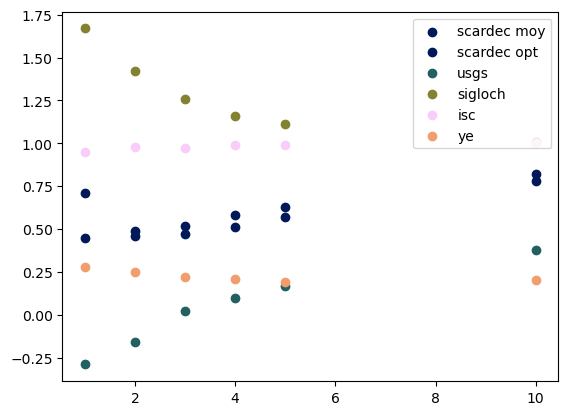

In [900]:
plt.scatter(window, scardec_moy_gradient, label='scardec moy', color=dataset_colors['scardec'])
plt.scatter(window, scardec_opt_gradient, label='scardec opt', color=dataset_colors['scardec'])
plt.scatter(window, usgs_gradient, label='usgs', color=dataset_colors['usgs'])
plt.scatter(window, sigloch_gradient, label='sigloch', color=dataset_colors['sigloch'])
plt.scatter(window, isc_gradient, label='isc', color=dataset_colors['isc'])
plt.scatter(window, ye_gradient, label='ye', color=dataset_colors['ye'])

plt.legend()

plt.show()

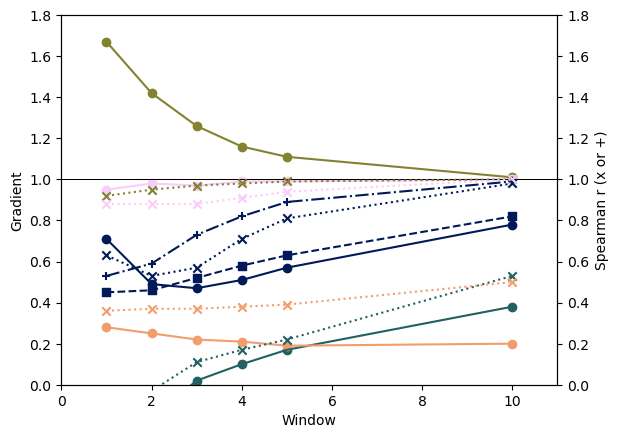

In [929]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.scatter(window, scardec_moy_gradient, label='scardec moy gradient', color=dataset_colors['scardec'])
ax1.scatter(window, scardec_opt_gradient, label='scardec opt gradient', color=dataset_colors['scardec'], marker = 's')
ax1.scatter(window, usgs_gradient, label='usgs gradient', color=dataset_colors['usgs'])
ax1.scatter(window, sigloch_gradient, label='sigloch gradient', color=dataset_colors['sigloch'])
ax1.scatter(window, isc_gradient, label='isc gradient', color=dataset_colors['isc'])
ax1.scatter(window, ye_gradient, label='ye gradient', color=dataset_colors['ye'])

ax1.plot(window, scardec_moy_gradient, color=dataset_colors['scardec'])
ax1.plot(window, scardec_opt_gradient, color=dataset_colors['scardec'], linestyle = '--')
ax1.plot(window, usgs_gradient, color=dataset_colors['usgs'])
ax1.plot(window, sigloch_gradient, color=dataset_colors['sigloch'])
ax1.plot(window, isc_gradient, color=dataset_colors['isc'])
ax1.plot(window, ye_gradient, color=dataset_colors['ye'])

ax2.scatter(window, scardec_moy_r, label='scardec moy r', color=dataset_colors['scardec'], marker='x')
ax2.scatter(window, scardec_opt_r, label='scardec opt r', color=dataset_colors['scardec'], marker='+')
ax2.scatter(window, usgs_r, label='usgs r', color=dataset_colors['usgs'], marker='x')
ax2.scatter(window, sigloch_r, label='sigloch r', color=dataset_colors['sigloch'], marker='x')
ax2.scatter(window, isc_r, label='isc r', color=dataset_colors['isc'], marker='x')
ax2.scatter(window, ye_r, label='ye r', color=dataset_colors['ye'], marker='x')
ax2.plot(window, scardec_moy_r, color=dataset_colors['scardec'], linestyle = ':')
ax2.plot(window, scardec_opt_r, color=dataset_colors['scardec'], linestyle = '-.')
ax2.plot(window, usgs_r, color=dataset_colors['usgs'], linestyle = ':')
ax2.plot(window, sigloch_r, color=dataset_colors['sigloch'], linestyle = ':')
ax2.plot(window, isc_r, color=dataset_colors['isc'], linestyle = ':')
ax2.plot(window, ye_r, color=dataset_colors['ye'], linestyle = ':')


ax1.set_xlabel('Window')
ax1.set_ylabel('Gradient')
ax2.set_ylabel('Spearman r (x or +)')


ax1.hlines(1, -1, 12, color='k', linewidth=0.75)
ax1.set_xlim(0, 11)
ax1.set_ylim(0, 1.8)
ax2.set_ylim(0, 1.8)
plt.show()

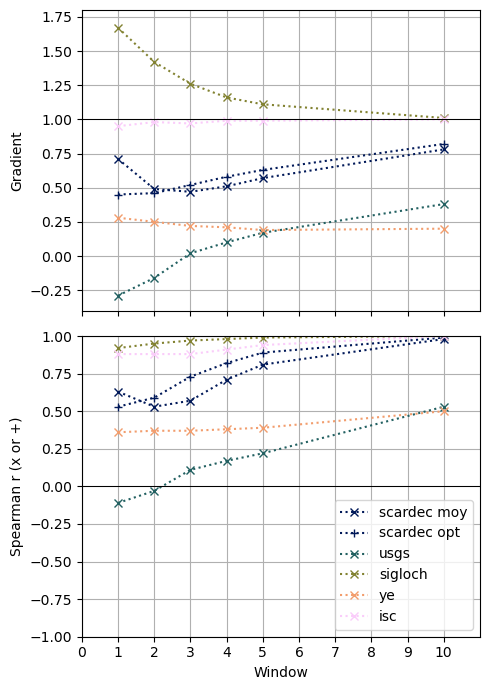

In [958]:
fig, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

ax1 = axs[0]
ax2 = axs[1]

ax1.plot(window, scardec_moy_gradient, color=dataset_colors['scardec'], linestyle = ':', marker = 'x', label='scardec moy')
ax1.plot(window, scardec_opt_gradient, color=dataset_colors['scardec'], linestyle = ':', marker = '+', label='scardec opt')
ax1.plot(window, usgs_gradient, color=dataset_colors['usgs'], linestyle = ':', marker = 'x', label='usgs')
ax1.plot(window, sigloch_gradient, color=dataset_colors['sigloch'], linestyle = ':', marker = 'x', label='sigloch')
ax1.plot(window, ye_gradient, color=dataset_colors['ye'], linestyle = ':', marker = 'x', label='ye')
ax1.plot(window, isc_gradient, color=dataset_colors['isc'], linestyle = ':', marker = 'x', label='isc')

ax2.plot(window, scardec_moy_r, color=dataset_colors['scardec'], linestyle = ':', marker='x', label='scardec moy')
ax2.plot(window, scardec_opt_r, color=dataset_colors['scardec'], linestyle = ':', marker='+', label='scardec opt')
ax2.plot(window, usgs_r, color=dataset_colors['usgs'], linestyle = ':', marker='x', label='usgs')
ax2.plot(window, sigloch_r, color=dataset_colors['sigloch'], linestyle = ':', marker='x', label='sigloch')
ax2.plot(window, ye_r, color=dataset_colors['ye'], linestyle = ':', marker='x', label='ye')
ax2.plot(window, isc_r, color=dataset_colors['isc'], linestyle = ':', marker='x', label='isc')


ax2.set_xlabel('Window')
ax1.set_ylabel('Gradient')
ax2.set_ylabel('Spearman r (x or +)')


ax1.hlines(1, -1, 12, color='k', linewidth=0.75)
ax2.hlines(0, -1, 12, color='k', linewidth=0.75)
ax1.set_xlim(0, 11)
ax1.set_ylim(-0.4, 1.8)
ax2.set_ylim(-1, 1)

ax1.set_xticks(np.arange(0, 11, 1))

ax1.grid()
ax2.grid()

ax2.legend()
plt.tight_layout()
plt.show()